In what follows we will walk an interested reader through the calculations.

# risk-neutral probability
The probability that the spot rate exceeds a certain threshold is found &ndash; no surprize here &ndash; by integrating the density of the spot rate from that threshold to infinity. The (risk-neutral) density can be estimated using the well-known result from [Breeden and Litzenberger (1978)](https://www.jstor.org/stable/2352653?seq=1#metadata_info_tab_contents): assuming that the price of a plain vanilla call option on an underlying asset $S$ at strike $K$ is given by function $C(S,K,\ldots)$, the risk-neutral density of $S$ is proportional to the second derivative of this function w.r.t. $K$:
$$q(S) \propto \frac{\partial^2 C(S,K,\ldots)}{\partial K^2},$$ 

with the proportionality constant equal to $\exp{r_c \tau}$, though it is just as easy to normalize the obtained density to make it sum up to 1.

# option pricing function
Function $C$ is unknown in general, but luckily, we do not need a general form to estimate its second derivative numerically &ndash; sufficient is that we can compute the value of $C$ for any strike. This can be achieved by interpolating the few observed market option prices or &ndash; an even better idea &ndash; by converting these prices to Black-Scholes (BS) implied volatilities, interpolating those, and getting the prices back using the BS formula. This way, $C$ becomes:

$$C(S, K, \ldots) = C^{bs}(S, \hat{\sigma}(K), K, \ldots),$$

where $\hat{\sigma}$ is a volatility smile function. Note that this does not assume the BS model is correct, only that it can be used to transform prices into something more conducive to interpolation. A good choice of the interpolating function for volatilities is a smile model such as SABR, which we will use in what follows. But what are the market values that we observe?

# option contracts
As it turns out, these are not option prices, but quotes of standard option contracts of a fixed delta, such as "at-the-money" contracts, "butterfly spreads" (aka "market strangles") and "risk reversals". The exact definitions of these differ between currency pairs, and we refer the reader to the excellent book ["Foreign Exchange Option Pricing: A Practitioner's Guide"](https://books.google.ch/books?id=7vua-0-2sgMC&redir_esc=y) by Iain Clark for further details. The quotes are related to the implied volatilities of the instruments' constituents; together with the spot and forward price and the interest rate in the base currency they allow to calibrate a SABR volatility smile. The calibration process is tricky, as described in ch. 3.7.1 of [Clark (2011)](https://books.google.ch/books?id=7vua-0-2sgMC&redir_esc=y), and in addition to data requires information about FX conventions for USDRUB, such as the definition of "at-the-money" and "delta". These can be found in Bloomberg.

# example
We will calculate the probability, as implied by market prices on on 24-Feb-2022 03:48am Zurich time, that USDRUB exceeds 85 when the 1-month contracts mature.

In what follows, `v_atm` denotes the quote of the at-the-money contract, `v_10b` (`v_25b`) &ndash; those of the 10-delta (25-delta) market strangle and `v_10r` (`v_25r`) &ndash; the IV of the 10-delta (25-delta) risk reversal.

In [16]:
import sys; sys.path.append("..")

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed

In [17]:
DATA_PATH = Path("../data")
MATURITY = 1/12  # maturity (approx) of options in the dataset, in years

plt.style.use("seaborn-v0_8-colorblind")

In [18]:
# data
data = pd.read_csv(DATA_PATH / "processed" / "data-example.csv")\
    .pivot(index="date", columns="contract", values="value")\
    .iloc[0]

data.to_frame().style.format(precision=4)

,2022-02-24 03:48:00+01:00
contract,
forward,82.1610
r_base,0.0023
r_counter,0.1293
spot,81.2420
v_10b,0.0747
v_10r,0.2661
v_25b,0.0150
v_25r,0.1221
v_atm,0.3583


Let's fit a SABR smile to these values and plot it for a range of strikes.

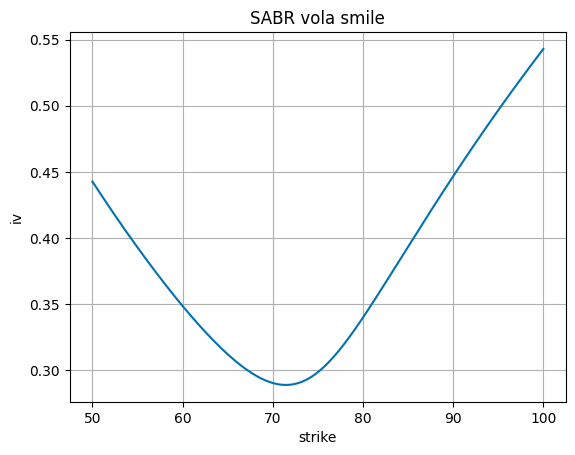

In [19]:
from optools.smile import SABR

# collect contracts as {delta: {market strangle: iv, risk reversal: iv}}
contracts={
    0.10: {
        "ms": data["v_10b"],
        "rr": data["v_10r"]
    },
    0.25: {
        "ms": data["v_25b"],
        "rr": data["v_25r"]
    }
}

# fit
sabr = SABR.fit_to_fx(
    tau=MATURITY,
    v_atm=data["v_atm"],
    contracts=contracts,
    delta_conventions={"atm_def": "dns",
                       "is_premiumadj": True,
                       "is_forward": False},
    **data[["spot", "forward", "r_counter", "r_base"]]
)

# plot
fig, ax = sabr.plot(domain=np.arange(50, 100, 1e-04))
ax.set_xlabel("strike")
ax.set_ylabel("iv")
ax.grid(axis="both")
ax.set_title("SABR vola smile")
plt.show()

Looks great! Now, with this smile at hand, we can compute the price of call options at any strike.

In [20]:
from optools.blackscholes import option_price

def option_pricer(_k):
    """Equation in #option_pricing_function above."""
    _res = option_price(
        strike=_k, vola=sabr(_k), forward=data["forward"],
        rf=data["r_counter"], tau=MATURITY, is_call=True
    )
    return _res

# some strikes
k_new = np.array([85, 95, 100.0])

# implied vola for each strike
iv_new = sabr(k_new)

# call option price for (k, iv) pairs
c_price = option_pricer(k_new)

pd.DataFrame({"strike": k_new, "iv": iv_new, "c_price": c_price})\
    .style.format(precision=2)

,strike,iv,c_price
0,85.00,0.39,2.51
1,95.00,0.50,1.02
2,100.00,0.54,0.70


This is enough to calculate the numerical second derivative as $\frac{(C(K+\Delta K) - C(K)) - (C(K) - C(K-\Delta K))}{\Delta K ^ 2}$.

In [21]:
from scipy.integrate import simps

def get_risk_neutral_density(dk, k_min, k_max, verbose=False):
    """Get normalized rnd on the globally defined date."""
    # range of strikes
    _k = np.arange(k_min-dk, k_max+dk, dk)
    
    # d^2 f(x) / dx^2, note that len(density) = len(k_range)-2
    _d = np.diff(
        option_pricer(_k), 
        n=2
    ) / dk ** 2

    # normalize to sum up to 1
    _d_integral = simps(_d, _k[1:-1])

    if verbose:
        print(f"numerical differentiation with dK = {dk:.1e} from K={k_min} to {k_max};")
        print(f"density sumps up to {_d_integral:.2}")

    return _d / _d_integral

The density should be positive everywhere and integrate to 1.0, which rarely happens due to numerical issues. We let the user experiment with different values of $\Delta K$ and domain of integration. We would expect the density to become vanishingly small at the levels of spot/2 on the left and spot*1.5 on the right.

In [22]:
# step size for strikes
dk_widget = widgets.FloatSlider(min=2e-05, max=1e-03, step=2e-05, 
                                readout_format='.1e')

# lower and upper limit of integration
k_min_widget = widgets.IntSlider(min=30, max=60, step=5)
k_max_widget = widgets.IntSlider(min=120, max=170, step=10)

display(
    _ = interact(get_risk_neutral_density, 
                 dk=dk_widget, 
                 k_min=k_min_widget, 
                 k_max=k_max_widget,
                 verbose=fixed(True))
)

interactive(children=(FloatSlider(value=2e-05, description='dk', max=0.001, min=2e-05, readout_format='.1e', s…

Finally, we can integrate the estimated density from a threshold of interest to ~~infinity~~ a very big value and arrive at the probability of the underlying exceeding that threshold.

In [23]:
# recalculate density at the given slider
rnd = get_risk_neutral_density(
    dk_widget.value, 
    k_min_widget.value,
    k_max_widget.value
)

# region of integration; two points are lost bc of differentiation twice
k_range = np.arange(
    k_min_widget.value-dk_widget.value, 
    k_max_widget.value+dk_widget.value, 
    dk_widget.value
)[1:-1]

@interact
def get_risk_neutral_probability_of_tail(threshold=(85, 105, 5)):
    # drop the left tail
    idx = k_range > threshold

    # integrate over the range of strikes from thresh to 'infinity'
    prob = simps(rnd[idx], k_range[idx])

    print(f"P[S>{threshold}] = {prob:.2f}")

interactive(children=(IntSlider(value=95, description='threshold', max=105, min=85, step=5), Output()), _dom_c…

The above calculations are implemented in `optools.smile.VolatilitySmile.estimate_risk_neutral_density`.